In [2]:
submissions_files = []
for root, dirs, files in os.walk("data/submissions"):
    # print(root, dirs, files)
    for name in files:
        submissions_files.append(os.path.join(root, name))

users_files = []
for root, dirs, files in os.walk("data/users"):
    for name in files:
        users_files.append(os.path.join(root, name))
        
len(submissions_files), len(users_files)

(74, 21627)

# Characterizing Online Attitudes

Topic model: LDA
Example: 
- [gensim: LDA model](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html)
- [Topic Modeling and Latent Dirichlet Allocation (LDA) in Python](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

## 1. Pre-process and vectorize the documents

Another approach to represent a document as a vector is the `bag-of-words` model. Under the bag-of-words model each document is represented by a vector containing the frequency counts of each word in the dictionary.

For example, assume we have a **dictionary** containing the words `['coffee', 'milk', 'sugar', 'spoon']`. A document consisting of the string "coffee milk coffee" would then be represented by the vector `[2, 1, 0, 0]`. One of the main properties of the bag-of-words model is that it completely ignores the order of the tokens in the document that is encoded, which is where the name bag-of-words comes from.


Reference:
- [gensim: Core Concepts](https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html#sphx-glr-auto-examples-core-run-core-concepts-py)
- [PRAW:The Python Reddit API Wrapper](https://praw.readthedocs.io/en/stable/)


In [3]:
import pickle, os, re
from pprint import pprint
from collections import defaultdict

from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
from gensim.utils import tokenize
from gensim.models import Phrases

# from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

In [5]:
# type(unpickle("data/submissions/1jnbak.pkl"))
# unpickle("data/users/_________FU_________.pkl")

In [4]:
def unpickle(file_path: str):
    with open(file_path, 'rb') as fo:
        return pickle.load(fo, encoding='bytes')


def submission_loader(dir_name: str):
    submissions = []  # list of Submissions
    
    print(f'Loading submissions from {dir_name}')
    for root, dirs, files in os.walk(dir_name):
        # print(root, dirs, files)
        for name in files:
            file_path = os.path.join(root, name)
            submissions.append(unpickle(file_path))  # unpickle file in submissions -> Submission
    
    return submissions


def commet_loader(dir_name: str):
    comments = []  # list of Users
    i = 0
    print(f'Loading comments from {dir_name}')
    for root, dirs, files in os.walk(dir_name):
        # print(root, dirs, files)
        for name in files:
            file_path = os.path.join(root, name)
            comments += unpickle(file_path)  # unpickle file in users -> list[Comments]
            i += 1
            if i % 1000 == 999:
                print(f"Done for first {i+1} files!")
    return comments


def extract_documents(submission):
    # concatenate comments in one submission into corpus
    # praw.models.reddit.submission.Submission
    documents = []
    comments = submission.comments.list()
    
    for comment in comments:
        documents.append(comment.body)  # should we remove punctuation???
        
    return documents

def extract_docs_from_comments(comments: list):
    # concatenate comments in a comments list to corpus
    # praw.models.reddit.submission.Comments
    # documents = []
    # comments = submission.comments.list()
    
    # for comment in comments:
    #     documents.append(comment.body)  # should we remove punctuation???
        
    return [comment.body for comment in comments]

### Explor data

In [8]:
# load submissions
submissions = submission_loader("data/submissions")
print(f'The number of submissions: {len(submissions)}')

# count [deleted] comments
documents = []
for submission in submissions: 
    documents += extract_documents(submission)

deleted = []
for doc in documents:
  if "[deleted]" in doc:
    deleted.append(doc)
print(f'number of deleted comments: {len(deleted)}')  

Loading submissions from data/submissions
The number of submissions: 74
number of deleted comments: 1221


In [20]:
def create_corpus(documents: list[str], stoplist=STOPWORDS):
    """ Create corpus by the following steps.
        - Clean text data
            - Remove url (r'http\S+')
            - Remove [deleted] comments
            - Tokenize and remove stopwords: 
                - `gensim.utils.tokenize(doc, lowercase=True)`
                - Stop rules: gensim.parsing.preprocessing.STOPWORDS + ADD_STOPWORDS
            - Remove numbers and Single letter: 
                - `token.isnumeric()`
                - `len(token) == 1`
            - Remove words that appear <= 5 times
            - Lemmatize the tokens
            - Add bi-grams: `gensim.models.Phrases(documents, min_count=20)`
            - Remove all empty doc  
        - Dictionary: gensim.corpora.Dictionary
            - Filter out words that occur less than 5 documents
            - or more than 30% of the documents
        - Corpus: Bag-of-words representation of the documents, `dictionary.doc2bow(doc)`

    Args:
        documents (list[str]): _description_
        stoplist (_type_, optional): _description_. Defaults to STOPWORDS.

    Returns:
        _type_: _description_
        corpus: _description_
        dictionary: _description_
        documents: _description_
        bigram: _description_
    """
    # remove url
    regex_rul = r'http\S+'
    documents = [re.sub(regex_rul, '', doc) for doc in documents]
    
    # Remove [deleted] comments
    for doc in documents:        
        if '[deleted]' in doc:
            documents.remove(doc)
        
    # Tokenize and remove common words 
    ADD_STOPWORDS = ['ve', 'bc', 'll', 'lol']
    documents = [
        [token for token in list(tokenize(doc, lowercase=True)) if token not in stoplist and token not in ADD_STOPWORDS]
        for doc in documents
    ]
    
    # Remove numbers, but not words that contain numbers. Remove single letter
    documents = [
        [token for token in doc if not token.isnumeric() and len(token) > 1] 
        for doc in documents
        ]
    
    # Remove rare words that appear <= 5 times
    rare_times = 5
    frequency = defaultdict(int)
    for doc in documents:
        for token in doc:
            frequency[token] += 1

    documents = [
        [token for token in doc if frequency[token] > rare_times]
        for doc in documents
    ]
    
    # Add bi-grams to docs (only ones that appear 20 times or more).
    bigram = Phrases(documents, min_count=20)
    print(f'bigram: {bigram}')
    documents = [bigram[doc] for doc in documents]
    
    # Lemmatize the gender tokens
    # male <- man, men; female <- woman, women
    for doc in documents:
        for idx, token in enumerate(doc):
            if token in ['man', 'men']:
                doc[idx] = 'male'
            elif token in ['woman', 'women']:
                doc[idx] = 'female'
    
    # Lemmatize the documents.
    lemmatizer = WordNetLemmatizer()
    documents = [
        [lemmatizer.lemmatize(token) for token in doc] 
        for doc in documents
        ]
    
    # Remove all empty doc
    documents = [doc for doc in documents if doc]
    
    # Create a dictionary representation of the documents.
    dictionary = Dictionary(documents)
    
    # Filter out words that occur less than 5 documents, or more than 30% of the documents.
    dictionary.filter_extremes(no_below=5, no_above=0.3)

    # Bag-of-words representation of the documents.
    corpus = [dictionary.doc2bow(doc) for doc in documents] 
    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of documents: %d' % len(corpus))
    
    return corpus, dictionary, documents, bigram # [[tokens]]

In [25]:
documents_all = []
for submission in submissions: 
    documents_all += extract_documents(submission)

corpus, dictionary, tokenized_docs, bigram = create_corpus(documents_all)

bigram: Phrases<316473 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>
Number of unique tokens: 6573
Number of documents: 39912


In [66]:
# tokenized_docs

In [68]:
# check empty doc
empty = 0
for idx, docs in enumerate(tokenized_docs):
    if not docs:
        empty += 1
print(f'Number of empty documents: {empty}')

Number of empty documents: 0


In [67]:
phrases = bigram.export_phrases()
phrases.keys()

dict_keys(['fda_approval', 'lasts_years', 'test_subjects', 'sperm_count', 'birth_control', 'family_planning', 'tl_dr', 'reproductive_organs', 'shoot_blanks', 'bullet_proof', 'proof_vest', 'sex_drive', 'paying_child', 'child_support', 'hell_yes', 'female_birth', 'protect_stds', 'male_birth', 'proven_safe', 'birth_controls', 'shooting_blanks', 'approved_fda', 'want_kids', 'hormonal_birth', 'use_condoms', 'shoot_bulletproof', 'bulletproof_vest', 'hell_yeah', 'long_term', 'use_condom', 'couple_years', 'local_anesthetic', 'wear_condoms', 'vas_deferens', 'having_sex', 'sperm_production', 'term_relationship', 'wear_condom', 'sounds_like', 'stick_condoms', 'clinical_trials', 'unprotected_sex', 'form_birth', 'makes_sense', 'polymer_gel', 'long_lasting', 'big_deal', 'male_version', 'hate_condoms', 'having_children', 'insurance_cover', 'depo_shot', 'read_article', 'years_ago', 'increased_risk', 'risk_stroke', 'health_insurance', 'unplanned_pregnancy', 'nuva_ring', 'pretty_sure', 'term_relationshi

In [69]:
# print(dictionary)
list(dictionary.items())[:10]

[(0, 'able'),
 (1, 'away'),
 (2, 'birth_control'),
 (3, 'bought'),
 (4, 'break'),
 (5, 'called'),
 (6, 'central'),
 (7, 'chemical'),
 (8, 'coat'),
 (9, 'come')]

## 2. Topic model on submissions

In [70]:
from gensim.models import LdaMulticore, LdaModel

In [91]:
def topic_model(corpus, dictionary, num_topics, 
                alpha = 'symmetric', eta ='symmetric', 
                save=False, fname="model"):
    # # Train topic model.
    # lda_model = LdaModel(corpus, id2word=dictionary, num_topics=10)
    
    # Set training parameters.
    chunksize = 2000  # Number of documents to be used in each training chunk.
    passes = 5  # Number of passes through the corpus during training.
    iterations = 400  # Maximum number of iterations through the corpus when inferring the topic distribution of a corpus.
    eval_every = 1  # Don't evaluate model perplexity, takes too much time.
    workers = 4 # Number of workers processes to be used for parallelization.
    
    # parameters
    num_topics = num_topics
    alpha = alpha
    eta = eta
    
    lda_model = LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, 
                             iterations=iterations, passes=passes, workers=workers)
    
    if save: 
        lda_model.save(fname="./model/" + fname)
        # # Load a potentially pretrained model from disk.
        # lda_model = LdaModel.load(temp_file)
    
    # Train a parallelized LDA
    return lda_model

def get_coherence(lda_model, corpus, texts, coherence='u_mass'):
    # For ‘c_v’, ‘c_uci’ and ‘c_npmi’ texts should be provided (corpus isn’t needed)
    # calculate average topic coherence
    top_topics = lda_model.top_topics(corpus, texts, coherence=coherence) 
    coherence_scores = [topic[1] for topic in top_topics]
    # print('Average topic coherence: %.4f' % avg_topic_coherence)
    
    return sum(coherence_scores) / len (coherence_scores)

In [92]:
lda_model = topic_model(corpus, dictionary, 8, save=True, fname="submissions_model")
# print out topics
for idx, topic in lda_model.print_topics(-1, ):
    print(f'Topic_{idx}: {topic}')

Topic_0: 0.015*"like" + 0.010*"comment" + 0.010*"thing" + 0.010*"male" + 0.010*"know" + 0.009*"people" + 0.008*"right" + 0.007*"question" + 0.007*"sure" + 0.007*"fucking"
Topic_1: 0.057*"female" + 0.034*"pill" + 0.029*"male" + 0.023*"effect" + 0.021*"birth_control" + 0.011*"think" + 0.009*"want" + 0.009*"taking" + 0.008*"control" + 0.007*"like"
Topic_2: 0.018*"effect" + 0.015*"male" + 0.014*"testosterone" + 0.012*"hormone" + 0.010*"pill" + 0.009*"people" + 0.009*"drug" + 0.009*"female" + 0.008*"like" + 0.008*"level"
Topic_3: 0.039*"male" + 0.038*"female" + 0.021*"effect" + 0.014*"birth_control" + 0.010*"condom" + 0.009*"risk" + 0.009*"control" + 0.008*"option" + 0.008*"people" + 0.007*"use"
Topic_4: 0.023*"control" + 0.018*"sperm" + 0.017*"study" + 0.015*"removed" + 0.014*"male" + 0.013*"pill" + 0.013*"like" + 0.013*"effect" + 0.012*"trial" + 0.012*"male_birth"
Topic_5: 0.028*"male" + 0.025*"yes" + 0.021*"child" + 0.020*"condom" + 0.020*"want" + 0.016*"female" + 0.009*"think" + 0.009*"

In [93]:
top_topics = lda_model.top_topics(corpus) 
coherence_scores = [topic[1] for topic in top_topics]
avg_topic_coherence = sum(coherence_scores) / len (coherence_scores)
print('Average topic coherence: %.4f' % avg_topic_coherence)

Average topic coherence: -2.5326


In [94]:
avg_coherence_score = get_coherence(lda_model, corpus, tokenized_docs, coherence='c_v')
print('Average topic coherence: %.4f' % avg_coherence_score)

Average topic coherence: 0.6425


### Visualize the topics

In [95]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [96]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
vis

/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.068182  0.061556       1        1  18.086962
3      0.100550  0.008614       2        1  16.918832
5      0.008232  0.155684       3        1  12.757702
2      0.082939 -0.085031       4        1  12.222424
7     -0.085009 -0.035219       5        1  11.352681
0     -0.027944  0.082160       6        1  10.610100
4      0.058047 -0.146293       7        1   9.504348
6     -0.204999 -0.041471       8        1   8.546951, topic_info=          Term          Freq         Total Category  logprob  loglift
227  vasectomy   2743.000000   2743.000000  Default  30.0000  30.0000
139     female  11714.000000  11714.000000  Default  29.0000  29.0000
530      child   1981.000000   1981.000000  Default  28.0000  28.0000
173        yes   2721.000000   2721.000000  Default  27.0000  27.0000
212       male  10804.000000  10804.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
168       good    222.681764   1577.761458   Topic8  -5.3409   0.5016
158       work    203.380116   1833.082689   Topic8  -5.4315   0.2609
87        want    222.756446   3748.792758   Topic8  -5.3405  -0.3635
467     people    211.480280   3441.213042   Topic8  -5.3925  -0.3299
80        time    208.018451   2860.868116   Topic8  -5.4090  -0.1617

[705 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.178951      able
0         2  0.138722      able
0         3  0.342642      able
0         4  0.073522      able
0         5  0.092943      able
...     ...       ...       ...
173       6  0.117567       yes
173       7  0.021309       yes
173       8  0.057681       yes
3572      8  0.947470     yikes
5430      3  0.902148  youngest

[2345 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 6, 3, 8, 1, 5, 7])

In [98]:
pyLDAvis.save_html(vis, 'lda.html')

### Hyperparameter Tuning

In [22]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
# Hyperparameter Tuning
def tuning(corpus, texts, dictionary, num_topics_list, alpha_list, eta_list, coherence='u_mass', save=False, fname="model"):
    
    best_model = None
    model_results = {'Topics': [], 'Alpha': [], 'Beta': [], 'Coherence': []}
    
    # Set training parameters.
    chunksize = 2000  # Number of documents to be used in each training chunk.
    passes = 10  # Number of passes through the corpus during training.
    iterations = 50  # Maximum number of iterations through the corpus when inferring the topic distribution of a corpus.
    eval_every = 1  # Don't evaluate model perplexity, takes too much time.
    workers = 4 # Number of workers processes to be used for parallelization.
    
    # Hyperparameter Tuning: num_topics, alpha, eta
    # alpha: Dirichlet hyperparameter alpha: Document-Topic Density
    # eta: Dirichlet hyperparameter beta: Word-Topic Density
    for num_topics in tqdm(num_topics_list, total=len(num_topics_list), desc='num_topics loop'):
        for alpha in alpha_list:
        # for alpha in tqdm(alpha_list, total=len(alpha_list), desc='alpha loop', position=0, leave=False):
            for eta in eta_list:
            # for eta in tqdm(eta_list, total=len(eta_list), desc='eta loop', position=0, leave=False):
                lda_model = LdaMulticore(corpus, num_topics=num_topics, alpha=alpha, eta=eta,
                                        id2word=dictionary, iterations=iterations, passes=passes, workers=workers)
                avg_coherence_score = get_coherence(lda_model, corpus, texts, coherence)
                
                # store best model
                if avg_coherence_score > max(model_results['Coherence']):
                    best_model = lda_model
                    
                # save results
                # model_results['Validation_Set'].append(corpus_title[i])
                model_results['Topics'].append(num_topics)
                model_results['Alpha'].append(alpha)
                model_results['Beta'].append(eta)
                model_results['Coherence'].append(avg_coherence_score) # Average topic coherence
                
    # save best model
    if save: 
        best_model.save(fname="./model/" + fname)
        # # Load a potentially pretrained model from disk.
        # lda_model = LdaModel.load(temp_file)
    
    return model_results

In [38]:
# Topics range
num_topics_list = range(2, 51, 1)

# Alpha parameter
alpha_list = [0.01]
# alpha_list = [0.01, 0.05, 0.1, 0.5, 1, 5, 10]
# alpha_list.append('symmetric')
# alpha_list.append('asymmetric')
# alpha_list.append('auto')

# Beta parameter
eta_list = [0.1]
# eta_list = [0.01, 0.05, 0.1, 0.5, 1, 5, 10]
# eta_list.append('symmetric')
# eta_list.append('auto')

coherence = 'c_v'
model_results = tuning(corpus, tokenized_docs, dictionary, num_topics_list, alpha_list, eta_list, coherence=coherence)

num_topics loop:   0%|          | 0/49 [00:00<?, ?it/s]

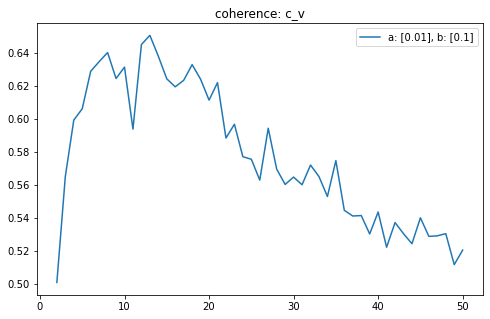

In [39]:
res = pd.DataFrame(model_results)
fig = plt.figure(figsize=(8, 5))
plt.plot(res.Topics,res.Coherence, label=f'a: {alpha_list}, b: {eta_list}')
plt.title(f'coherence: {coherence}')
plt.legend()
path = './plot/'
plt.savefig(f'{path}{coherence}_{alpha_list}_{eta_list}.png')

In [ ]:
# Topics range
num_topics_list = range(5, 20, 1)

# Alpha parameter
alpha_list = []
# alpha_list = [0.01, 0.05, 0.1, 0.5, 1, 5, 10]
alpha_list.append('symmetric')
# alpha_list.append('asymmetric')
# alpha_list.append('auto')

# Beta parameter
eta_list = []
# eta_list = [0.01, 0.05, 0.1, 0.5, 1, 5, 10]
# eta_list.append('symmetric')
eta_list.append('symmetric')

coherence = 'c_v'
model_results = tuning(corpus, tokenized_docs, dictionary, num_topics_list, alpha_list, eta_list, coherence=coherence)

res = pd.DataFrame(model_results)
fig = plt.figure(figsize=(8, 5))
plt.plot(res.Topics,res.Coherence, label=f'a: {alpha_list}, b: {eta_list}')
plt.title(f'coherence: {coherence}')
plt.legend()
path = './plot/'
plt.savefig(f'{path}{coherence}_{alpha_list}_{eta_list}.png')

In [ ]:
pd.DataFrame(model_results)

,Topics,Alpha,Beta,Coherence
0,2,symmetric,symmetric,0.562137
1,3,symmetric,symmetric,0.603818
2,4,symmetric,symmetric,0.592083
3,5,symmetric,symmetric,0.638605
4,6,symmetric,symmetric,0.637391
5,7,symmetric,symmetric,0.648285
6,8,symmetric,symmetric,0.634165
7,9,symmetric,symmetric,0.648581
8,10,symmetric,symmetric,0.615697
9,11,symmetric,symmetric,0.642329


In [44]:
def vis_model_results(model_results, coherence, alpha_list, eta_list):
    
    res = pd.DataFrame(model_results)
    
    fig = plt.figure(figsize=(8, 5))
    plt.plot(res.Topics, res.Coherence, label=f'a: {alpha_list}, b: {eta_list}')
    plt.title(f'coherence: {coherence}')
    plt.legend()
    path = './plot/'
    plt.savefig(f'{path}{coherence}_{alpha_list}_{eta_list}.png')

In [139]:
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()

import pyLDAvis.gensim_models as gensimvis

In [72]:
# best model
corpus, dictionary, processed_documents, bigram = create_corpus(documents_all)

# Set training parameters.
chunksize = 2000  # Number of documents to be used in each training chunk.
passes = 10  # Number of passes through the corpus during training.
iterations = 50  # Maximum number of iterations through the corpus when inferring the topic distribution of a corpus.
eval_every = 1  # Don't evaluate model perplexity, takes too much time.
workers = 4 # Number of workers processes to be used for parallelization.

# tuning
num_topics = 8
alpha = 'symmetric'
eta ='symmetric'
texts = processed_documents

lda_model = LdaMulticore(corpus, num_topics=num_topics, alpha=alpha, eta=eta,
                        id2word=dictionary, iterations=iterations, passes=passes, workers=workers)
                
avg_coherence_score = get_coherence(lda_model, corpus, texts, coherence='c_v')
avg_coherence_score

Phrases<312283 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>
Number of unique tokens: 6563
Number of documents: 39912


0.62606194687466

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [73]:
for idx, topic in lda_model.print_topics(-1, 10):
    print(f'Topic_{idx}: {topic}')
    
vis = gensimvis.prepare(lda_model, corpus, dictionary)
vis

Topic_0: 0.027*"year" + 0.026*"condom" + 0.020*"like" + 0.018*"time" + 0.014*"pill" + 0.012*"effective" + 0.011*"day" + 0.009*"use" + 0.008*"sex" + 0.007*"going"
Topic_1: 0.029*"male" + 0.021*"study" + 0.012*"trial" + 0.009*"article" + 0.008*"research" + 0.007*"people" + 0.007*"read" + 0.006*"female" + 0.006*"said" + 0.005*"participant"
Topic_2: 0.069*"female" + 0.067*"male" + 0.032*"birth_control" + 0.020*"pill" + 0.017*"yes" + 0.015*"condom" + 0.012*"option" + 0.012*"want" + 0.011*"pregnancy" + 0.009*"think"
Topic_3: 0.019*"testosterone" + 0.014*"drug" + 0.012*"sperm" + 0.009*"level" + 0.009*"hormone" + 0.009*"sure" + 0.008*"body" + 0.007*"cause" + 0.007*"male" + 0.006*"work"
Topic_4: 0.040*"vasectomy" + 0.015*"iud" + 0.012*"year" + 0.012*"removed" + 0.012*"procedure" + 0.012*"pain" + 0.011*"wife" + 0.010*"pill" + 0.010*"doctor" + 0.010*"period"
Topic_5: 0.017*"child" + 0.016*"people" + 0.016*"want" + 0.013*"kid" + 0.012*"know" + 0.011*"like" + 0.011*"think" + 0.009*"sex" + 0.009*"ri

/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.105465  0.100638       1        1  20.227834
5      0.064483  0.121595       2        1  16.288432
7     -0.156334  0.030340       3        1  15.655947
4      0.128246  0.070355       4        1  11.681697
1     -0.130320 -0.085620       5        1  10.393367
3     -0.063581 -0.167153       6        1   9.455484
0      0.057337  0.059787       7        1   9.119570
6      0.205634 -0.129941       8        1   7.177669, topic_info=          Term          Freq         Total Category  logprob  loglift
139     female  12655.000000  12655.000000  Default  30.0000  30.0000
272     effect   6780.000000   6780.000000  Default  29.0000  29.0000
212       male  12883.000000  12883.000000  Default  28.0000  28.0000
227  vasectomy   2713.000000   2713.000000  Default  27.0000  27.0000
166     condom   3343.000000   3343.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
168       good    160.008891   1557.955533   Topic8  -5.4988   0.3583
256       know    168.898362   2990.738343   Topic8  -5.4447  -0.2398
351        way    152.773065   2279.247138   Topic8  -5.5451  -0.0685
166     condom    154.415239   3343.415675   Topic8  -5.5344  -0.4409
90        year    147.592138   2928.570706   Topic8  -5.5796  -0.3536

[648 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2133      1  0.364689      abortion
2133      2  0.624981      abortion
2133      5  0.001392      abortion
2133      7  0.008352      abortion
6348      2  0.983501  abso_fucking
...     ...       ...           ...
173       5  0.008765           yes
173       6  0.039443           yes
173       7  0.050399           yes
173       8  0.182240           yes
294       7  0.948731     yesterday

[1905 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 8, 5, 2, 4, 1, 7])

In [62]:
pd.DataFrame(lda_model.top_topics(corpus=corpus, texts=texts))

,0,1
0,"[(0.03649474, condom), (0.030338807, pill), (0...",-2.399345
1,"[(0.026540875, study), (0.02529187, male), (0....",-2.429542
2,"[(0.057105877, effect), (0.05528798, female), ...",-2.484197
3,"[(0.03942287, male), (0.034425523, female), (0...",-2.491193
4,"[(0.056572918, male), (0.051221088, female), (...",-2.769312
5,"[(0.022356292, yes), (0.014739549, kid), (0.01...",-2.864911
6,"[(0.019755514, sperm), (0.014585196, body), (0...",-2.928497
7,"[(0.024034027, vasectomy), (0.018796077, year)...",-3.088578


## 3. Topic model on users' comments

In [7]:
# # read most first 4000 files
# users = commet_loader("data/users")
# len(users)

Loading comments from data/users
Done for first 1000 files!
Done for first 2000 files!
Done for first 3000 files!
Done for first 4000 files!


## Things to experiment with

- [BERTopic](https://maartengr.github.io/BERTopic/)